In [1]:
import numpy as np
np.random.seed(42)

## Neuron

In [19]:
class Neuron(object):
    """
    Process an input vector, return activation
    Args:
        num_inputs (int) : input size
        activation_function (callable) : activation function
    Attributes:
        W (array): weight values for each input
        b (float): bias
        activation_function (callable): activation function
    """

    def __init__(self, num_inputs, activation_function):
        super().__init__()

        self.W = np.random.uniform(size=num_inputs, low=-1., high=1.)
        self.b = np.random.uniform(size=1, low=-1., high=1.)

        self.activation_function = activation_function

    def forward(self, x):
        """
        Compute input through neuron, return the activation value
        Args : 
            x (ndarray): input vector. shape must be (1, num_inputs)
        Returns:
            activation (ndarray): activation value, of shape (1, layer_size)
        """
        z = np.dot(x, self.W) + self.b
        return self.activation_function(z)
        

Adding step function to have a perceptron : 

In [62]:
input_size = 6

step_function = lambda y: 0 if y <= 0 else 1

perceptron = Neuron(num_inputs=input_size, activation_function=step_function)
print("Perceptron's random weights = {} , and random bias = {}".format(perceptron.W, perceptron.b))

Perceptron's random weights = [ 0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547 ] , and random bias = [0.19579996]


In [64]:
# random input vector : 
x = np.random.rand(input_size).reshape(1, input_size)
print("Input vector : {}".format(x))

Input vector : [[0.92187424 0.0884925  0.19598286 0.04522729 0.32533033 0.38867729]]


In [66]:
y = perceptron.forward(x)
print("Perceptron's output value given `x` : {}".format(y))

Perceptron's output value given `x` : 1


## Fully connected layer

In [71]:
class FullyConnectedLayer(object):
    """
    Args:
        num_inputs (int): input vector size .
        layer_size (int): number of neurons in the layer.
        activation_function (callable): activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
    """

    def __init__(self, num_inputs, layer_size, activation_function):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size
        self.activation_function = activation_function

    def forward(self, x):
        """
        Forward the input vector through the layer
        """
        z = np.dot(x, self.W) + self.b
        return self.activation_function(z)


In [87]:
x1 = np.random.uniform(-1,1,2).reshape(1,2)
x2 = np.random.uniform(-1,1,2).reshape(1,2)

In [89]:
relu_fn = lambda y: np.maximum(y, 0)

In [91]:
layer = FullyConnectedLayer(2, 3, relu_fn)

In [93]:
out1 = layer.forward(x1)
out2 = layer.forward(x2)

print(out1)
print(out2)

[[0.92846182 4.10050346 0.        ]]
[[0.97876643 3.70290315 0.21685685]]


## Simple Network

Let's take our fully connected layer and add backpropagation

In [103]:
class FullyConnectedLayer(object):
    """
    Args:
        num_inputs (int): input vector size .
        layer_size (int): number of neurons in the layer.
        activation_function (callable): activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.

        x (ndarray): last provided input vector, stored for backpropagation
        y (ndarray): corresponding output, stored for backpropagation
        derivated_activation_function (callable): corresponding derivated activation function
        dL_dW (ndarray): derivative of loss with respect to W
        dL_db (ndarray): derivative of loss with respect to b
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size
        
        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        
        self.x = None
        self.y = None
        self.dL_dW = None
        self.dL_db = None

    def forward(self, x):
        """
        Forward the input vector through the layer
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x # (storing value)
        return self.y

    def backward(self, dL_dy):
        """
        Back-propagate the loss, computing all the derivatives, storing those with respect to the layer parameters,
        and returning the loss with respect to its inputs for further propagation.
        Args:
            dL_dy (ndarray): The loss derivative with respect to the layer's output (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): The loss derivative with respect to the layer's input (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # Computing the derivatives with respect to the layer's parameters, and storing them for optimization:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # Computing the derivative with respect to the input, to be passed to the previous layers (their `dL_dy`):
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        Optimize the layer's parameters, using the stored derivative values.
        Args:
            epsilon (float): The learning rate.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db

In [105]:
# Activation functions

def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def derivated_sigmoid(y):
    return y * (1 - y)

In [107]:
# Loss function 

def loss_MSE(pred, target):             # L2/MSE loss 
    return np.sum(np.square(pred - target)) / pred.shape[0] 

def derivated_loss_MSE(pred, target):   # L2 derivative 
    return 2 * (pred - target)

def binary_cross_entropy(pred, target):            # cross-entropy loss
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))

def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative 
    return (pred - target) / (pred * (1 - pred))

In [109]:
class SimpleNetwork(object):
    """A simple fully-connected NN.
    Args:
        num_inputs (int): input vector size 
        num_outputs (int): output vector size
        hidden_layers_sizes (list): A list of sizes for each hidden layer to add to the network
        activation_function (callable): The activation function for all the layers
        derivated_activation_function (callable): The derivated activation function
        loss_function (callable): The loss function to train this network
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation
    Attributes:
        layers (list): The list of layers forming this simple network.
        loss_function (callable): The loss function to train this network.
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation.
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_MSE, derivated_loss_function=derivated_loss_MSE):
        super().__init__()
        # We build the list of layers composing the network, according to the provided arguments:
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Forward the input vector through the layers, returning the output vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`.
        Returns:
            activation (ndarray): The output activation value, of shape `(batch_size, layer_size)`.
        """
        for layer in self.layers: # from the input layer to the output one
            x = layer.forward(x)
        return x

    def predict(self, x):
        """
        Compute the output corresponding to input `x`, and return the index of the largest 
        output value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`.
        Returns:
            best_class (int): The predicted class ID.
        """
        estimations = self.forward(x)
        best_class = np.argmax(estimations)
        return best_class

    def backward(self, dL_dy):
        """
        Back-propagate the loss hrough the layers (require `forward()` to be called before).
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the network's output (dL/dy).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the network's input (dL/dx).
        """
        for layer in reversed(self.layers): # from the output layer to the input one
            dL_dy = layer.backward(dL_dy)
        return dL_dy

    def optimize(self, epsilon):
        """
        Optimize the network parameters according to the stored gradients (require `backward()`
        to be called before).
        Args:
            epsilon (float): The learning rate.
        """
        for layer in self.layers:             # the order doesn't matter here
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
        Returns:
            accuracy (float): The accuracy of the network 
                              (= number of correct predictions/dataset size).
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset.
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset
                # Get batch:
                batch_index_begin = b * batch_size
                batch_index_end = batch_index_begin + batch_size
                x = X_train[batch_index_begin: batch_index_end]
                targets = y_train[batch_index_begin: batch_index_end]
                # Optimize on batch:
                predictions = y = self.forward(x)  # forward pass
                L = self.loss_function(predictions, targets)  # loss computation
                dL_dy = self.derivated_loss_function(predictions, targets)  # loss derivation
                self.backward(dL_dy)  # back-propagation pass
                self.optimize(learning_rate)  # optimization of the NN
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies

## Implementation with mnist

In [116]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [122]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [126]:
num_classes = 10

In [132]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Image :


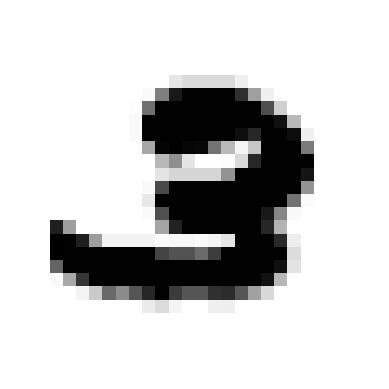

----------------------------------------------------------------------------------------------------
True label : 3


In [150]:
print("Image :")
img_idx = np.random.randint(0, X_test.shape[0])
plt.imshow(X_test[img_idx], cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()

print("--"*50)
print("True label :", y_test[img_idx])

In [152]:
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

In [154]:
X_train.shape

(60000, 784)

In [156]:
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

Pixel values between 0 and 255


In [158]:
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))

Normalized pixel values between 0.0 and 1.0


In [160]:
y_train = np.eye(num_classes)[y_train]

Data is prepped, let's create our network to fit the data

In [165]:
mnist_classifier = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, 
                                 hidden_layers_sizes=[64, 32])

In [167]:
predictions = mnist_classifier.forward(X_train)                         # forward pass
loss_untrained = mnist_classifier.loss_function(predictions, y_train)   # loss computation

accuracy_untrained = mnist_classifier.evaluate_accuracy(X_test, y_test)  # Accuracy
print("Untrained : training loss = {:.6f} | val accuracy = {:.2f}%".format(
    loss_untrained, accuracy_untrained * 100))

Untrained : training loss = 2.643254 | val accuracy = 11.13%


Performance before training is as expected, around 10%. All seems normal at this point.

In [170]:
losses, accuracies = mnist_classifier.train(X_train, y_train, X_test, y_test, 
                                            batch_size=20, num_epochs=100)

Epoch    0: training loss = 0.950690 | val accuracy = 19.70%
Epoch   20: training loss = 0.305614 | val accuracy = 78.71%
Epoch   40: training loss = 0.187389 | val accuracy = 88.65%
Epoch   60: training loss = 0.150658 | val accuracy = 90.54%
Epoch   80: training loss = 0.131212 | val accuracy = 91.58%
Epoch   99: training loss = 0.118551 | val accuracy = 92.19%


80% accuracy after 20 epochs, almost 90 after 40 epochs